# House Prices Prediction using Stacking Modeling

# Import Libraries

In [4]:
import numpy as np 
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

# Statistical library
from scipy import stats
from scipy.stats import norm, skew 
from scipy.special import boxcox1p

# Missing value visualization
import missingno as msno

# Seaborn configuration style
sns.set_style("darkgrid")

# Import data

## Training data

In [8]:
# Read data
dataset = pd.read_csv("C:/Carpeta personal/Professional/kaggle-competitions/house-prices-advanced-regression-techniques/house-prices-advanced-regression-techniques/train.csv")
# Dataset dimensions
print(f"Shape of the dataset: {dataset.shape}")
# Show data sample
dataset.head()

Shape of the dataset: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Exploration Data Analysis (EDA)

### Check duplicated Ids

In [9]:
print("There are {0} duplicated Ids".format(dataset['Id'].duplicated().sum()))
# Drop Id column
dataset = dataset.drop(['Id'], axis=1)

There are 0 duplicated Ids


### Check dataset dtype

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## Exploring Sale Price column

<Axes: xlabel='SalePrice', ylabel='Density'>

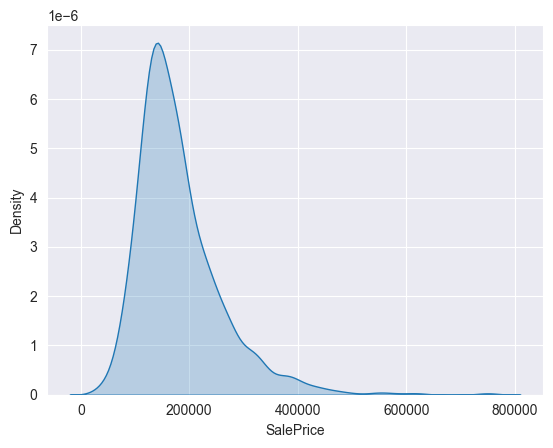

In [11]:
# Distribution of the sale price column
sns.kdeplot(
    data=dataset,
    x="SalePrice",    
    fill=True    
)

<p style="font-size:16px;">
The Sale Price column is right skewed. The proper form to treat this type of variables with linear models is convert the data to normally distributed data. When the data is 
</p>

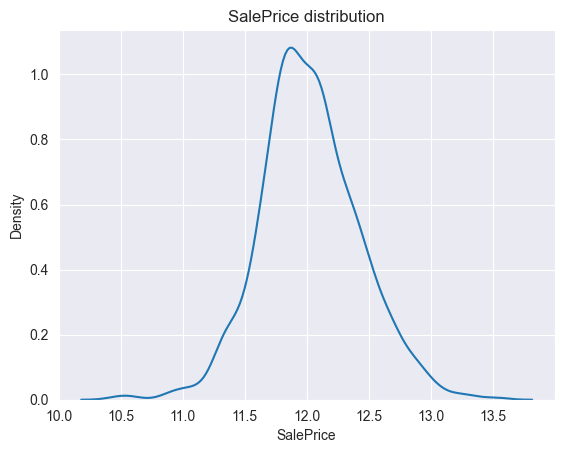

In [12]:
dataset['SalePrice'] = np.log(dataset['SalePrice'])

# New distribution 
sns.kdeplot(dataset['SalePrice'])
plt.title('SalePrice distribution')
plt.show()

## Missing values

<Axes: >

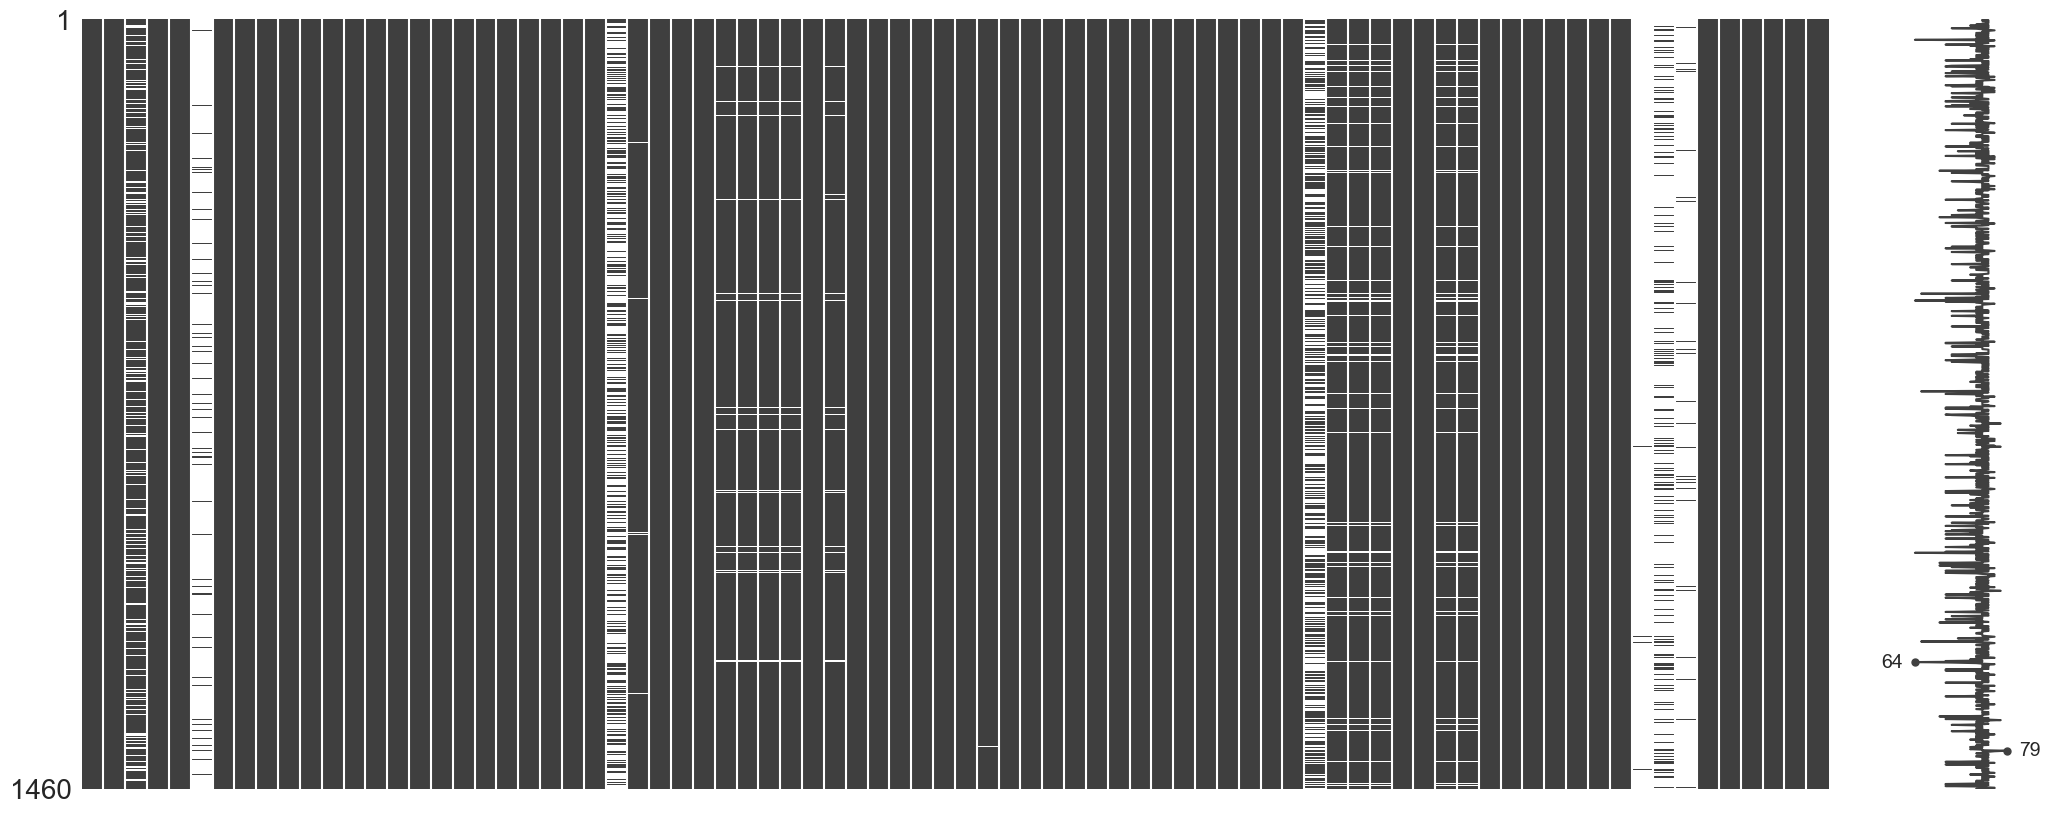

In [13]:
# Visualize missing values
msno.matrix(dataset)

In [14]:
# Check the columns with missing values
print(dataset.columns[dataset.isna().sum() > 0])

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


<p style="font-size:16px;">According to the dataset description, missing data appears in columns where a category of "No ..." or something similar exists. Also, when the categorical columns "GarageType" does not contain "Garage", or when the column "MasVnrType" contains "None", the values for "GarageYrBlt" and "MasVnrArea" are set to 0, rather than being considered as missing values.</p>

In [15]:
# Categorical columns where missing values were found
target_missing_columns = {
    "Alley": "No Alley",
    "LotFrontage": 0.0,
    "MasVnrType": "None",
    "BsmtQual": "No basement",
    "BsmtCond": "No basement",
    "BsmtExposure": "No basement",
    "BsmtFinType1": "No basement",
    "BsmtFinType2": "No basement",
    "FireplaceQu": "No Fireplace",
    "GarageType": "No Garage",
    "GarageFinish": "No Garage",
    "GarageQual": "No Garage",
    "GarageCond": "No Garage",
    "PoolQC": "No Pool",
    "Fence": "No Fence",
    "MiscFeature": "None"
}
# Dependent columns
missing_dependent_columns = {
    "MasVnrArea": ["MasVnrType", "None"],
    "GarageYrBlt": ["GarageType", "No Garage"]    
}

### Handling missing categories

In [16]:
for column, fill_value in target_missing_columns.items():    
    dataset[column] = dataset[column].fillna(fill_value)  

### Handling missing values of dependent columns

In [17]:
for dependent_column, (column, value) in missing_dependent_columns.items():
    dataset.loc[dataset[column] == value, dependent_column] = 0    

### Drop the missing values from the "Electrical" column

In [18]:
dataset = dataset.dropna(subset=["Electrical"])
dataset = dataset.reset_index(drop=True)

<Axes: >

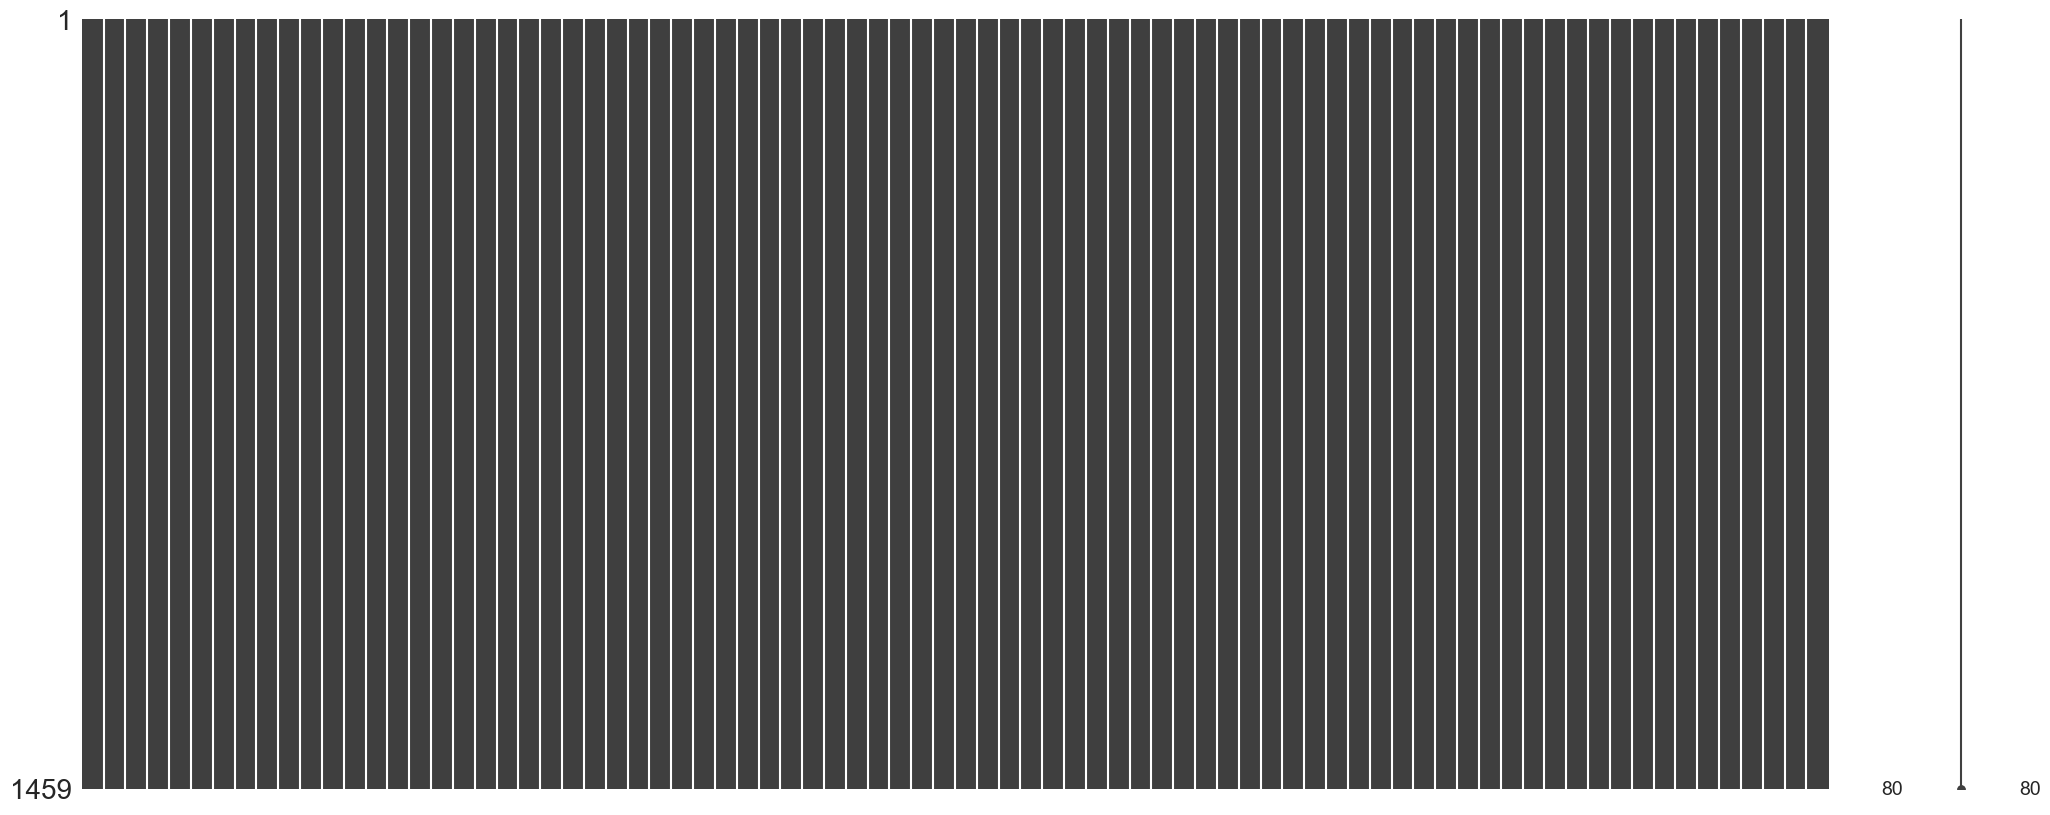

In [19]:
# Visualize missing values
msno.matrix(dataset)

## Correction of fields

Convert all the categorical columns to object type

In [20]:
categorical_columns = (
    "MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", \
    "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", \
    "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond", \
    "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "HeatingQC", "CentralAir", "Electrical", \
    "KitchenQual", "Functional", \
    "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence", \
    "MiscFeature", "YrSold", "SaleType", "SaleCondition"    
)
auto_label_encoder = [
    "OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath", \
    "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", \
    "Fireplaces", "GarageCars", "MoSold"
]

In [21]:
dataset[list(auto_label_encoder)].dtypes

OverallQual     int64
OverallCond     int64
BsmtFullBath    int64
BsmtHalfBath    int64
FullBath        int64
HalfBath        int64
BedroomAbvGr    int64
KitchenAbvGr    int64
TotRmsAbvGrd    int64
Fireplaces      int64
GarageCars      int64
MoSold          int64
dtype: object

In [22]:
def change_dtype(dataset, column, type):
    """
        To change the type of the columns of the dataset
        Args:
            dataset (pandas DataFrame)
            column (string): Columns to change
            type (string): New type for the columns
    """
    return dataset[column].astype(type)

# Convert to the right type
for cat_column in categorical_columns:
    dataset[cat_column] = change_dtype(dataset, cat_column, "object")

In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   object 
 1   MSZoning       1459 non-null   object 
 2   LotFrontage    1459 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          1459 non-null   object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1459 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

# Preprocessing Data

In [24]:
# Get the features and labels
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

## Convert to Label Encoder

Label Encoder can be useful in categorical variables that give some notion of ordinal sort, ratings or categorical values represented as numbers

In [25]:
# List of categorical columns to Label Encoder
target_le_columns = (
    "MSSubClass", "LotShape", "LandContour", "LandSlope", \
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", \
    "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", \
    "KitchenQual", "FireplaceQu", "GarageFinish", "GarageQual", \
    "GarageCond", "PavedDrive", "PoolQC", "Fence", "YrSold"    
)

**Apply Label Encoder to the data**

In [26]:
from sklearn.preprocessing import LabelEncoder

for column in target_le_columns:
    # Encoder
    encoder = LabelEncoder()    
    X[column] = encoder.fit_transform(X[column].values)
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,5,RL,65.0,8450,Pave,No Alley,3,3,AllPub,Inside,...,0,0,3,4,None,0,2,2,WD,Normal
1,0,RL,80.0,9600,Pave,No Alley,3,3,AllPub,FR2,...,0,0,3,4,None,0,5,1,WD,Normal
2,5,RL,68.0,11250,Pave,No Alley,0,3,AllPub,Inside,...,0,0,3,4,None,0,9,2,WD,Normal
3,6,RL,60.0,9550,Pave,No Alley,0,3,AllPub,Corner,...,0,0,3,4,None,0,2,0,WD,Abnorml
4,5,RL,84.0,14260,Pave,No Alley,0,3,AllPub,FR2,...,0,0,3,4,None,0,12,2,WD,Normal


In [27]:
numeric_feats = X.dtypes[X.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,24.443278
PoolArea,14.807992
LotArea,12.190881
3SsnPorch,10.290132
LowQualFinSF,8.998885
LandSlope,4.806884
KitchenAbvGr,4.482026
BsmtFinSF2,4.249219
ScreenPorch,4.116334
BsmtHalfBath,4.097541


In [82]:
dataset["MiscVal"].value_counts()

MiscVal
0        1407
400        11
500         8
700         5
450         4
600         4
2000        4
1200        2
480         2
15500       1
800         1
350         1
3500        1
1300        1
54          1
620         1
560         1
1400        1
8300        1
1150        1
2500        1
Name: count, dtype: int64

In [28]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lambda_value = 0.0
for feat in skewed_features:    
    X[feat] = np.log1p(X[feat])

There are 55 skewed numerical features to Box Cox transform


Convert categorical variables to dummies

In [29]:
X = pd.get_dummies(X)
X.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.791759,4.189655,9.042040,1.386294,1.386294,0.0,2.079442,1.791759,7.602900,7.602900,...,False,False,False,True,False,False,False,False,True,False
1,0.000000,4.394449,9.169623,1.386294,1.386294,0.0,1.945910,2.197225,7.589336,7.589336,...,False,False,False,True,False,False,False,False,True,False
2,1.791759,4.234107,9.328212,0.000000,1.386294,0.0,2.079442,1.791759,7.601902,7.602401,...,False,False,False,True,False,False,False,False,True,False
3,1.945910,4.110874,9.164401,0.000000,1.386294,0.0,2.079442,1.791759,7.557995,7.586296,...,False,False,False,True,True,False,False,False,False,False
4,1.791759,4.442651,9.565284,0.000000,1.386294,0.0,2.197225,1.791759,7.601402,7.601402,...,False,False,False,True,False,False,False,False,True,False


# Ensemble Modeling

In [47]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import ElasticNet

from sklearn.preprocessing import RobustScaler

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

## Base models

### Lasso

In [50]:
lasso = Lasso(alpha=0.0005, random_state=10)

### Support Vector Machine

In [49]:
svm = SVR(C=0.1, kernel="linear")

### kNN

In [51]:
knn = KNeighborsRegressor(n_neighbors=5)

### Elastic Net

In [48]:
elastic_net = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=11)

### ExtraTrees

In [52]:
xtra_trees = ExtraTreesRegressor(
    n_estimators=1000,
    max_depth=5,
    min_samples_leaf=15,
    min_samples_split=10,
    random_state=13
)

### RandomForest

In [53]:
rf = RandomForestRegressor(
    n_estimators=3000,
    max_depth=5,
    min_samples_leaf=15,
    min_samples_split=10,
    random_state=14
)

### GradientBoosting

In [54]:
gbr = GradientBoostingRegressor(
    n_estimators=1000,
    max_depth=5,
    min_samples_leaf=15,
    min_samples_split=10,
    loss="huber",
    max_features="sqrt",
    random_state=15
)

### Cross-validation

In [55]:
from sklearn.model_selection import KFold
n_folds = 5
kf = KFold(n_folds, shuffle=True, random_state=42)

In [38]:
X_train_folds, X_test_folds = [], []
y_train_folds, y_test_folds = [], []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}")
    X_train_folds.append(X.iloc[train_index])
    X_test_folds.append(X.iloc[test_index])
    y_train_folds.append(y.iloc[train_index])
    y_test_folds.append(y.iloc[test_index])

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


### Train and Test base models

In [58]:
scores = np.empty((6, n_folds))
y_test_true = pd.DataFrame([])
test_predictions = pd.DataFrame([])
rmse = np.empty((6, n_folds))

for i, (X_train, X_test, y_train, y_test) in enumerate(zip(X_train_folds, X_test_folds, y_train_folds, y_test_folds)):
    print(f"Fold {i}")
    rs = RobustScaler()    
    scaled_X_train = rs.fit_transform(X_train)
    scaled_X_test = rs.transform(X_test)
    
    lasso.fit(scaled_X_train, y_train)
    svm.fit(scaled_X_train, y_train)
    elastic_net.fit(scaled_X_train, y_train)
    knn.fit(scaled_X_train, y_train)
    xtra_trees.fit(X_train, y_train)
    rf.fit(X_train, y_train)
    

    scores[0, i] = lasso.score(scaled_X_test, y_test)
    lasso_pred = lasso.predict(scaled_X_test)    
    rmse[0, i] = np.sqrt(mean_squared_error(y_test, lasso_pred))

    scores[1, i] = svm.score(scaled_X_test, y_test)
    svm_pred = svm.predict(scaled_X_test)    
    rmse[1, i] = np.sqrt(mean_squared_error(y_test, svm_pred))

    scores[2, i] = elastic_net.score(scaled_X_test, y_test)
    elastic_net_pred = elastic_net.predict(scaled_X_test)
    rmse[2, i] = np.sqrt(mean_squared_error(y_test, elastic_net_pred))

    scores[3, i] = knn.score(scaled_X_test, y_test)
    knn_pred = knn.predict(scaled_X_test)
    rmse[3, i] = np.sqrt(mean_squared_error(y_test, knn_pred))

    scores[4, i] = xtra_trees.score(X_test, y_test)
    xtra_trees_pred = xtra_trees.predict(X_test)
    rmse[4, i] = np.sqrt(mean_squared_error(y_test, xtra_trees_pred))

    scores[5, i] = rf.score(X_test, y_test)
    rf_pred = rf.predict(X_test)
    rmse[5, i] = np.sqrt(mean_squared_error(y_test, rf_pred))
    

    test_predictions = pd.concat([test_predictions, pd.Series(lasso_pred), pd.Series(svm_pred), pd.Series(elastic_net_pred),\
                                                  pd.Series(knn_pred), pd.Series(xtra_trees_pred), pd.Series(rf_pred)], axis=0)

print(f"Lasso mean score: {scores[0].mean()}, Lasso std: {scores[0].std()}, RMSE: {rmse[0].mean()}, {rmse[0].std()}")
print(f"SVM mean score: {scores[1].mean()}, SVM std: {scores[1].std()}, RMSE: {rmse[1].mean()}, {rmse[1].std()}")
print(f"KNN mean score: {scores[2].mean()}, KNN std: {scores[2].std()}, RMSE: {rmse[2].mean()}, {rmse[2].std()}")
print(f"Extra Trees mean score: {scores[3].mean()}, Extra Trees std: {scores[3].std()}, RMSE: {rmse[3].mean()}, {rmse[3].std()}")
print(f"Random Forest mean score: {scores[4].mean()}, Random Forest std: {scores[4].std()}, RMSE: {rmse[4].mean()}, {rmse[4].std()}")
print(f"Gradient Boosting mean score: {scores[5].mean()}, Gradient Boosting std: {scores[5].std()}, RMSE: {rmse[5].mean()}, {rmse[5].std()}")

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Lasso mean score: 0.8922340517497058, Lasso std: 0.03579355014463418, RMSE: 0.12914134657572812, 0.020022984639046393
SVM mean score: 0.8880266013294318, SVM std: 0.03762926803072043, RMSE: 0.131552507535482, 0.02022324549695168
KNN mean score: 0.8921446602128411, KNN std: 0.035692224688032216, RMSE: 0.12920075034227038, 0.019950065674680013
Extra Trees mean score: 0.7547845106016207, Extra Trees std: 0.02602885373156735, RMSE: 0.19703890716463746, 0.01627737157801319
Random Forest mean score: 0.8174494402970793, Random Forest std: 0.011284466373973973, RMSE: 0.17022536965512214, 0.012538142479868078
Gradient Boosting mean score: 0.8271955336825405, Gradient Boosting std: 0.020043391229018236, RMSE: 0.16537819469469114, 0.013864081357788329


## Retrain with all data

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Retrain models

In [60]:
rs = RobustScaler()
scaled_X_train = rs.fit_transform(X_train)
lasso.fit(scaled_X_train, y_train)
svm.fit(scaled_X_train, y_train)
elastic_net.fit(scaled_X_train, y_train)
knn.fit(scaled_X_train, y_train)
xtra_trees.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=15, min_samples_split=10,
                      n_estimators=3000, random_state=14)

### Predictions

In [62]:
predictions = pd.DataFrame([])

predictions = pd.concat([predictions, pd.Series(lasso.predict(rs.transform(X_test)))], axis=1)
predictions = pd.concat([predictions, pd.Series(svm.predict(rs.transform(X_test)))], axis=1)
predictions = pd.concat([predictions, pd.Series(elastic_net.predict(rs.transform(X_test)))], axis=1)
predictions = pd.concat([predictions, pd.Series(knn.predict(rs.transform(X_test)))], axis=1)
predictions = pd.concat([predictions, pd.Series(xtra_trees.predict(X_test))], axis=1)
predictions = pd.concat([predictions, pd.Series(rf.predict(X_test))], axis=1)

predictions.columns = ["Lasso", "SVM", "ElasticNet", "KNN", "ExtraTrees", "RandomForest"]

### Train the meta-learner model

In [63]:
gbr.fit(predictions, y_test)

GradientBoostingRegressor(loss='huber', max_depth=5, max_features='sqrt',
                          min_samples_leaf=15, min_samples_split=10,
                          n_estimators=1000, random_state=15)

### Meta-learner Tested

In [66]:
train_predictions = pd.DataFrame([])
train_predictions = pd.concat([train_predictions, pd.Series(lasso.predict(rs.transform(X_train)))], axis=1)
train_predictions = pd.concat([train_predictions, pd.Series(svm.predict(rs.transform(X_train)))], axis=1)
train_predictions = pd.concat([train_predictions, pd.Series(elastic_net.predict(rs.transform(X_train)))], axis=1)
train_predictions = pd.concat([train_predictions, pd.Series(knn.predict(rs.transform(X_train)))], axis=1)
train_predictions = pd.concat([train_predictions, pd.Series(xtra_trees.predict(X_train))], axis=1)
train_predictions = pd.concat([train_predictions, pd.Series(rf.predict(X_train))], axis=1)

train_predictions.columns = ["Lasso", "SVM", "ElasticNet", "KNN", "ExtraTrees", "RandomForest"]

In [72]:
train_predictions.shape

(1167, 6)

In [75]:
train_pred_meta = gbr.predict(train_predictions)
train_pred_meta = train_pred_meta.reshape(-1, 1)
train_pred_meta.shape

(1167, 1)

In [76]:
y_train = y_train.values.reshape(-1, 1)
y_train.shape

(1167, 1)

In [80]:
print(gbr.score(train_predictions, y_train))
print(np.sqrt(mean_squared_error(y_train, train_pred_meta)))


0.8830641492465379
0.13523063649531056
